In [45]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import os
import cv2 as cv2
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import legendre
from scipy.optimize import leastsq
from scipy.interpolate import griddata
import scipy
import h5py
from scipy.spatial import KDTree
import tifffile
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [27]:
allFiles=glob.glob(r'D:\L4\AustinPoke\Poke_Phasics\*.tif')
img0=cv2.imread(allFiles[0],-1)[20:-20,20:-20]
nx,ny=img0.shape
maty=img0.flatten().shape[0]
matx=np.size(allFiles)
data_mat=np.zeros((matx,maty))
k=-1
for file_ in allFiles:
    k+=1
    temp=cv2.imread(file_,-1)[20:-20,20:-20]
    data_mat[k,:]=temp.flatten()

In [118]:
pca=PCA(n_components=50)
u,s,v=pca._fit(data_mat.T)


In [100]:
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis
pca_scores=np.zeros(50)
fa_scores=np.zeros(50)
k=-1
A=data_mat.T
for n_ in range(1,50):
    k+=1
    print(k)
    pca = PCA(n_components=n_)
    u,s,v=pca._fit(A)
    pca_scores[k]=pca.score(A)
    
    transformer = FactorAnalysis(n_components=n_, random_state=0)
    X_transformed = transformer.fit_transform(A)
    fa_scores[k]=transformer.score(A)
    
    #print(pca.score(A))
    #print(cross_val_score(pca, A))
plt.plot(pca_scores,label='PCA')
plt.plot(fa_scores,label='FA')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


C:\Users\gavin.friedman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\decomposition\factor_analysis.py:238: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


40


C:\Users\gavin.friedman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\decomposition\factor_analysis.py:238: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


41


C:\Users\gavin.friedman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\decomposition\factor_analysis.py:238: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


42


KeyboardInterrupt: 

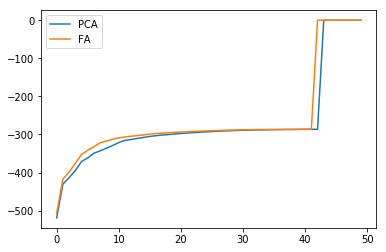

In [101]:
plt.plot(pca_scores,label='PCA')
plt.plot(fa_scores,label='FA')
plt.legend()

In [104]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA

A=data_mat.T

transformerICA = FastICA(n_components=50,random_state=0)
ICA_img = transformerICA.fit_transform(A)



Text(0.5, 0.98, 'Original')

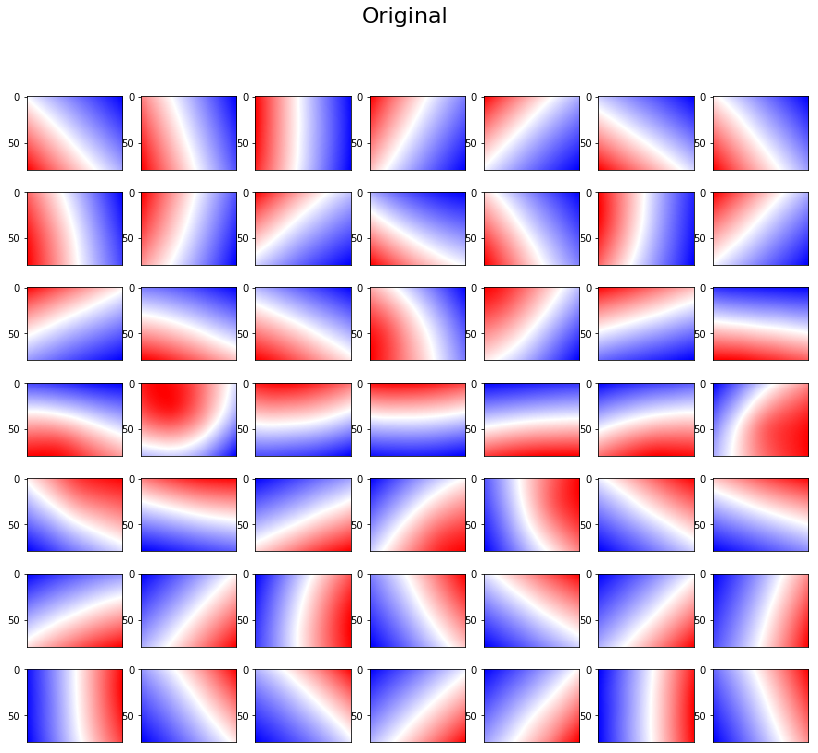

In [130]:
fig,ax=plt.subplots(7,7,figsize=(14,12))
for i in range(0,7):
    for j in range(0,7):
        ax[i][j].imshow(data_mat.T[:,7*i+j].reshape(nx,ny),cmap='bwr')
        ax[i][j].axes.get_xaxis().set_ticks([])
        #temp=np.abs(ICA_img[:,7*i+j]).reshape(nx,ny)
        #ax[i][j].set_title(str(np.unravel_index(temp.argmax(), temp.shape)))
plt.suptitle('Original',fontsize=(22))


Text(0.5, 0.98, 'ICA Analysis of Poke')

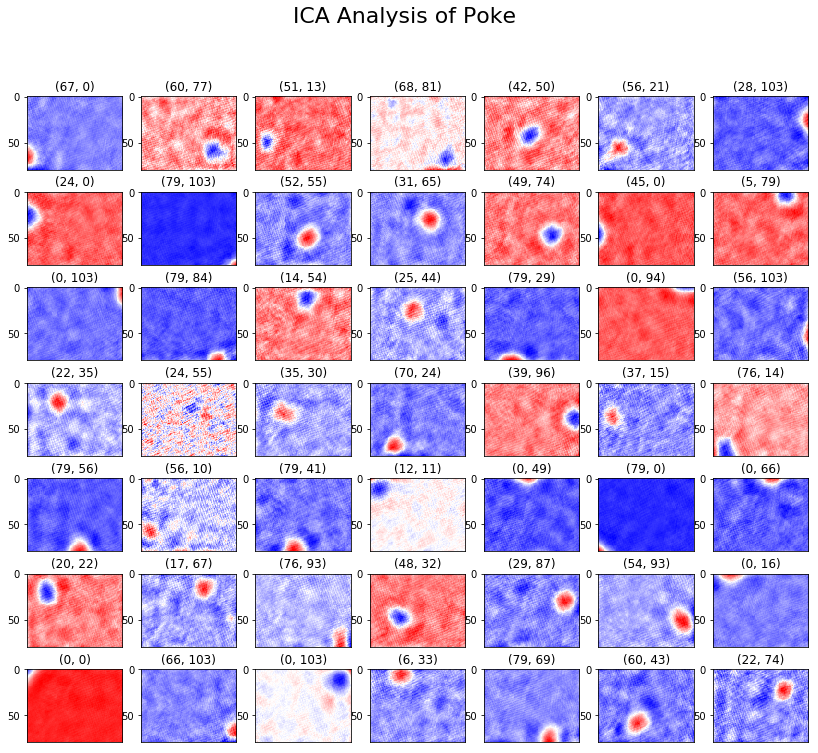

In [128]:
fig,ax=plt.subplots(7,7,figsize=(14,12))
for i in range(0,7):
    for j in range(0,7):
        ax[i][j].imshow(ICA_img[:,7*i+j].reshape(nx,ny),cmap='bwr')
        ax[i][j].axes.get_xaxis().set_ticks([])
        temp=np.abs(ICA_img[:,7*i+j]).reshape(nx,ny)
        ax[i][j].set_title(str(np.unravel_index(temp.argmax(), temp.shape)))
plt.suptitle('ICA Analysis of Poke',fontsize=(22))

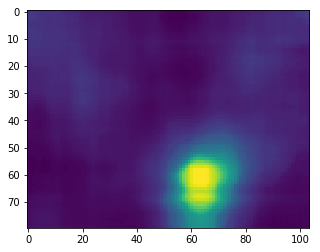

In [145]:
from scipy import ndimage
plt.imshow(scipy.ndimage.median_filter(temp,25))

In [290]:
def gauss2d(X, xo, yo, sigma_x, sigma_y, amplitude):
    x,y=X 
    g = amplitude*np.exp( - (((x-xo)**2)/(2*sigma_x**2) + ((y-yo)**2)/(2*sigma_y**2)))
    return g

In [275]:
temp

array([[0.0002628 , 0.00788886, 0.00279834, ..., 0.00095073, 0.00288674,
        0.01029855],
       [0.0067156 , 0.00357598, 0.0055611 , ..., 0.00469387, 0.00014145,
        0.00631557],
       [0.01241028, 0.00290389, 0.00036787, ..., 0.00179258, 0.0032468 ,
        0.00482677],
       ...,
       [0.01199641, 0.01248779, 0.00027769, ..., 0.00048276, 0.00853274,
        0.00352774],
       [0.01623495, 0.00914294, 0.00830164, ..., 0.00935674, 0.00934808,
        0.00078343],
       [0.01452156, 0.00134581, 0.00568055, ..., 0.00548777, 0.00435007,
        0.01101301]])

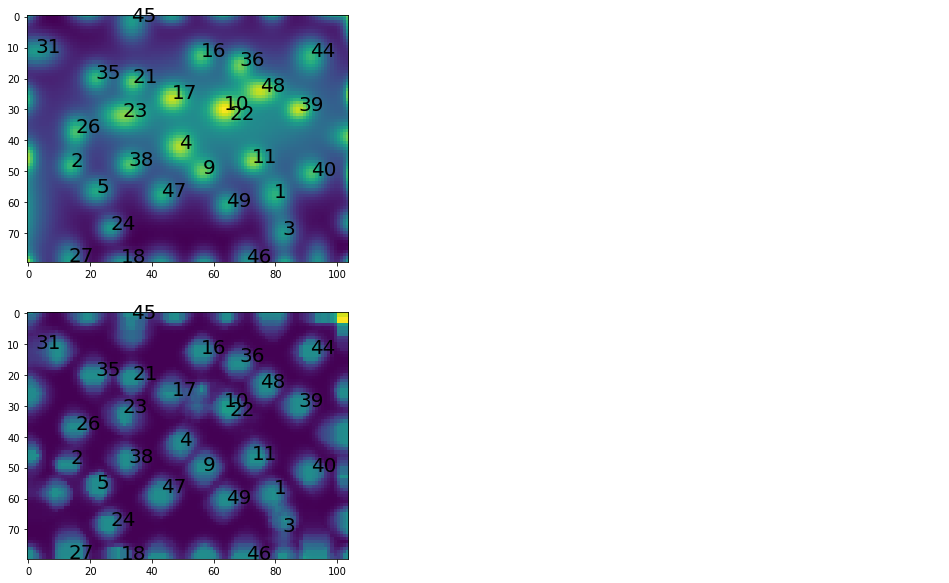

In [333]:
from scipy.optimize import leastsq
total_img=np.zeros((nx,ny))
total_img2=np.zeros((nx,ny))
fig,ax=plt.subplots(2,1,figsize=(10,10))
for i in range(1,50):
    temp=np.abs(ICA_img[:,i]).reshape(nx,ny).astype(float)
    #temp=temp-np.mean(temp)
    temp=scipy.ndimage.median_filter(temp,15)
    x0=nx/2
    y0=ny/2
    amp0=temp.max()
    offset=temp.mean()
    sigmax=nx/10
    sigmay=ny/10


    total_img2+=(temp/temp.max())**8
    X=[xv,yv]
    xi=x0,y0,sigmax,sigmay,amp0
    out=leastsq(cost_gauss,x0=xi,args=(X,temp))
    total_img+=(gauss2d(X,*out[0])/gauss2d(X,*out[0]).max())**8
    
    x=out[0][0]
    y=out[0][1]
    #plt.scatter(y,x,marker='s',s=140)
    ax[0].imshow(total_img)
    ax[1].imshow(total_img2)
    if x>0 and y>0:
        ax[0].annotate(str(i),xy=(x,y),fontsize=20)
        ax[1].annotate(str(i),xy=(x,y),fontsize=20)
    
#plt.xlim((0,nx))
#plt.ylim((0,ny))

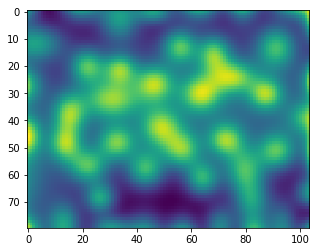

In [323]:
plt.imshow(total_img)

In [292]:
def cost_gauss(C,X,test):
    xo, yo, sigma_x, sigma_y, amplitude= C
    err=gauss2d(X, xo, yo, sigma_x, sigma_y, amplitude)-test
    err=err**2
    err=err.flatten()
    #err=np.sum(err)
    return err

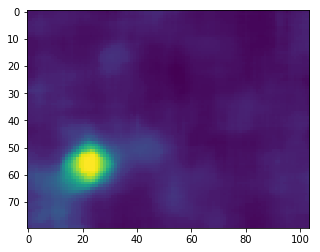

In [321]:
temp=np.abs(ICA_img[:,5]).reshape(nx,ny).astype(float)
temp=scipy.ndimage.median_filter(temp,15)
plt.imshow(temp)

In [221]:
popt

array([ 3.69488678e+00,  5.35546021e+00,  7.48840506e+00,  9.52829525e+00,
        8.49036828e-04, -2.06088233e-03])

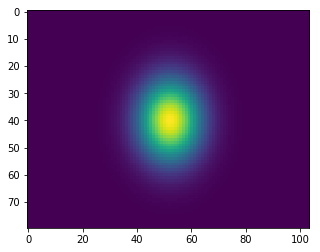

In [211]:
ny,nx=
x=np.arange(ny)
y=np.arange(nx)
xv,yv=np.meshgrid(x,y)
xs=xv.flatten()
ys=yv.flatten()

x0=ny/2
y0=nx/2
amp0=temp.max()
offset=temp.mean()
sigmax=nx/10
sigmay=ny/10

test=gauss2d((xv,yv),x0,y0,sigmax,sigmay,amp0,offset)
plt.imshow(test.reshape(nx,ny))



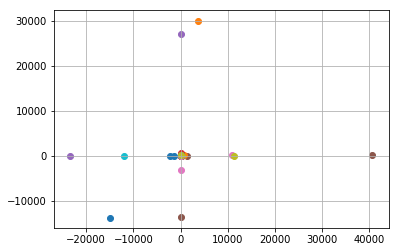

In [283]:
total_img=np.zeros((nx,ny))
for i in range(1,50):
    temp=np.abs(ICA_img[:,i]).reshape(nx,ny)
    temp=temp-np.mean(temp)
    #temp=scipy.ndimage.median_filter(temp,55)
    total_img+=temp
    
    x0=nx/2
    y0=ny/2
    amp0=temp.max()
    offset=temp.mean()
    sigmax=nx/10
    sigmay=ny/10



    X=[xv,yv]
    xi=x0,y0,sigmax,sigmay,amp0,offset
    out=leastsq(cost_gauss,x0=xi,args=(X,temp))
    x=out[0][0]
    y=out[0][1]
    #x,y=(np.unravel_index(temp.argmax(), temp.shape))
    plt.scatter(y,x)
plt.grid()
plt.ylim((0,nx))
plt.xlim((0,ny))

Text(0.5, 0.98, 'SVD Analysis of Poke')

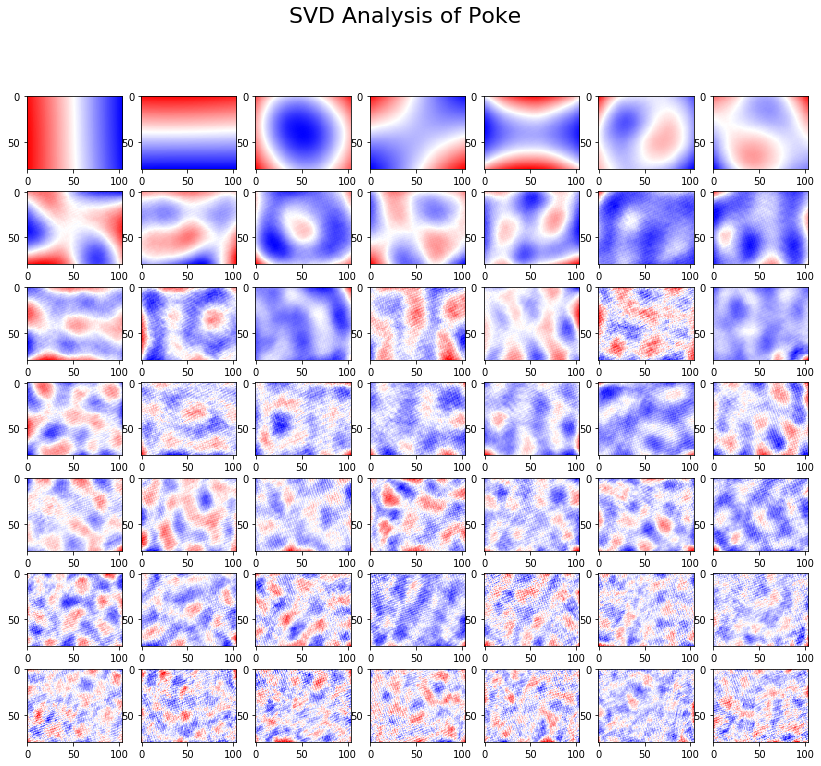

In [119]:
fig,ax=plt.subplots(7,7,figsize=(14,12))
for i in range(0,7):
    for j in range(0,7):
        ax[i][j].imshow(u[:,7*i+j].reshape(nx,ny),cmap='bwr')
plt.suptitle('SVD Analysis of Poke',fontsize=(22))

<ErrorbarContainer object of 3 artists>

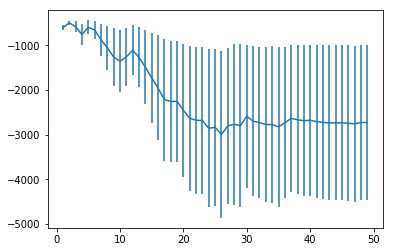

In [92]:
pca_score=np.zeros(49)
pca_score_std=np.zeros(49)
for n_ in range(1,50):
    
    pca=PCA(n_components=n_)
    u,s,v=pca._fit(data_mat.T)
    #pca_score[n_-1]=pca.score(data_mat.T)
    pca_score[n_-1]=np.mean(cross_val_score(pca,data_mat.T,cv=))
    pca_score_std[n_-1]=np.std(cross_val_score(pca,data_mat.T,cv=3))
plt.errorbar(range(1,50),pca_score,pca_score_std)
    

In [42]:
allFiles=glob.glob(r'D:\L4\AustinPoke\ColdWF\*.tif')
img0=cv2.imread(allFiles[0],-1)[20:-20,20:-20]
nx,ny=img0.shape
maty=img0.flatten().shape[0]
matx=np.size(allFiles)
test_mat=np.zeros((matx,maty))
k=-1
for file_ in allFiles:
    k+=1
    temp=cv2.imread(file_,-1)[20:-20,20:-20]
    test_mat[k,:]=temp.flatten()


In [49]:
print(cross_val_score(pca,data_mat.T,cv=5))
print(cross_val_score(pca,data_mat.T,y=test_mat.T,cv=5))

[-1027.59223169  -312.30100686  -307.02603907  -308.72240022
 -1260.11066354]
[-1027.59223169  -312.30100686  -307.02603907  -308.72240022
 -1260.11066354]


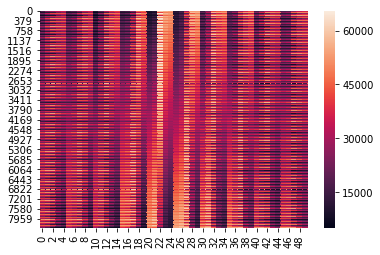

In [89]:
sns.heatmap(data_mat.T)

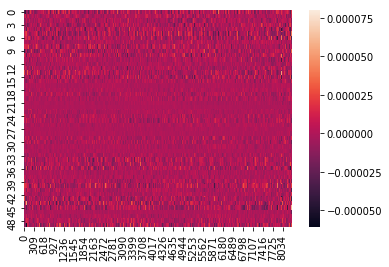

In [90]:
sns.heatmap(control_mat)

In [50]:
control_mat=scipy.linalg.pinv(data_mat.T)

In [87]:
control_mat=v.T @ np.diag(1/s) @ u.T
#test-control_mat

In [88]:
test_wf=test_mat[0,:]
act_commands=-1*control_mat@test_wf
pred_wf_delta=data_mat.T@act_commands
resid=test_wf+pred_wf_delta
print (np.std(test_wf),np.std(pred_wf_delta),np.std(resid))


5093.257761997297 4540.126252311465 2308.3605098027274


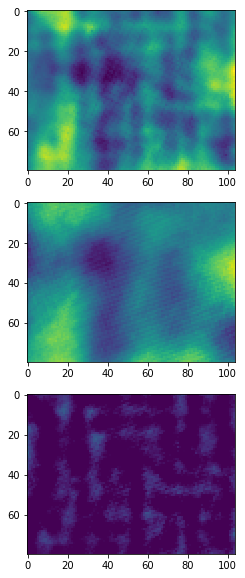

In [74]:
fig,ax=plt.subplots(3,1,figsize=(5,10))

vmax=test_wf.max()
vmin=test_wf.min()

ax[0].imshow(test_wf.reshape(nx,ny),vmin=vmin,vmax=vmax)
ax[1].imshow(-1*pred_wf_delta.reshape(nx,ny),vmin=vmin,vmax=vmax)
ax[2].imshow(resid.reshape(nx,ny),vmin=vmin,vmax=vmax)

